In [22]:
# Bruno Ugolini

# <center>__Preamble: Rationale for Date Shift__</center>
## The Regression discontinuity design (RDD) method was first applied to the active cases of Covid-19 in Quebec around the three dates of interest:
1. March 20, 2020: First lockdown.
2. August 31, 2020: start of school.
3. December 25, 2020: Recent lockdown

## When looking at 2) it was noted that a marked discontinuity was present one week after the date (see figure below). It was decided to repeat the final analysis using a one week shift to the right of the dates enumerated above to capture the discontinuities. This is justified since we would not expect the effects of a lockdown to be reflected in the propagation data of an infectious disease with an incubation period as in the case of Covid-19.

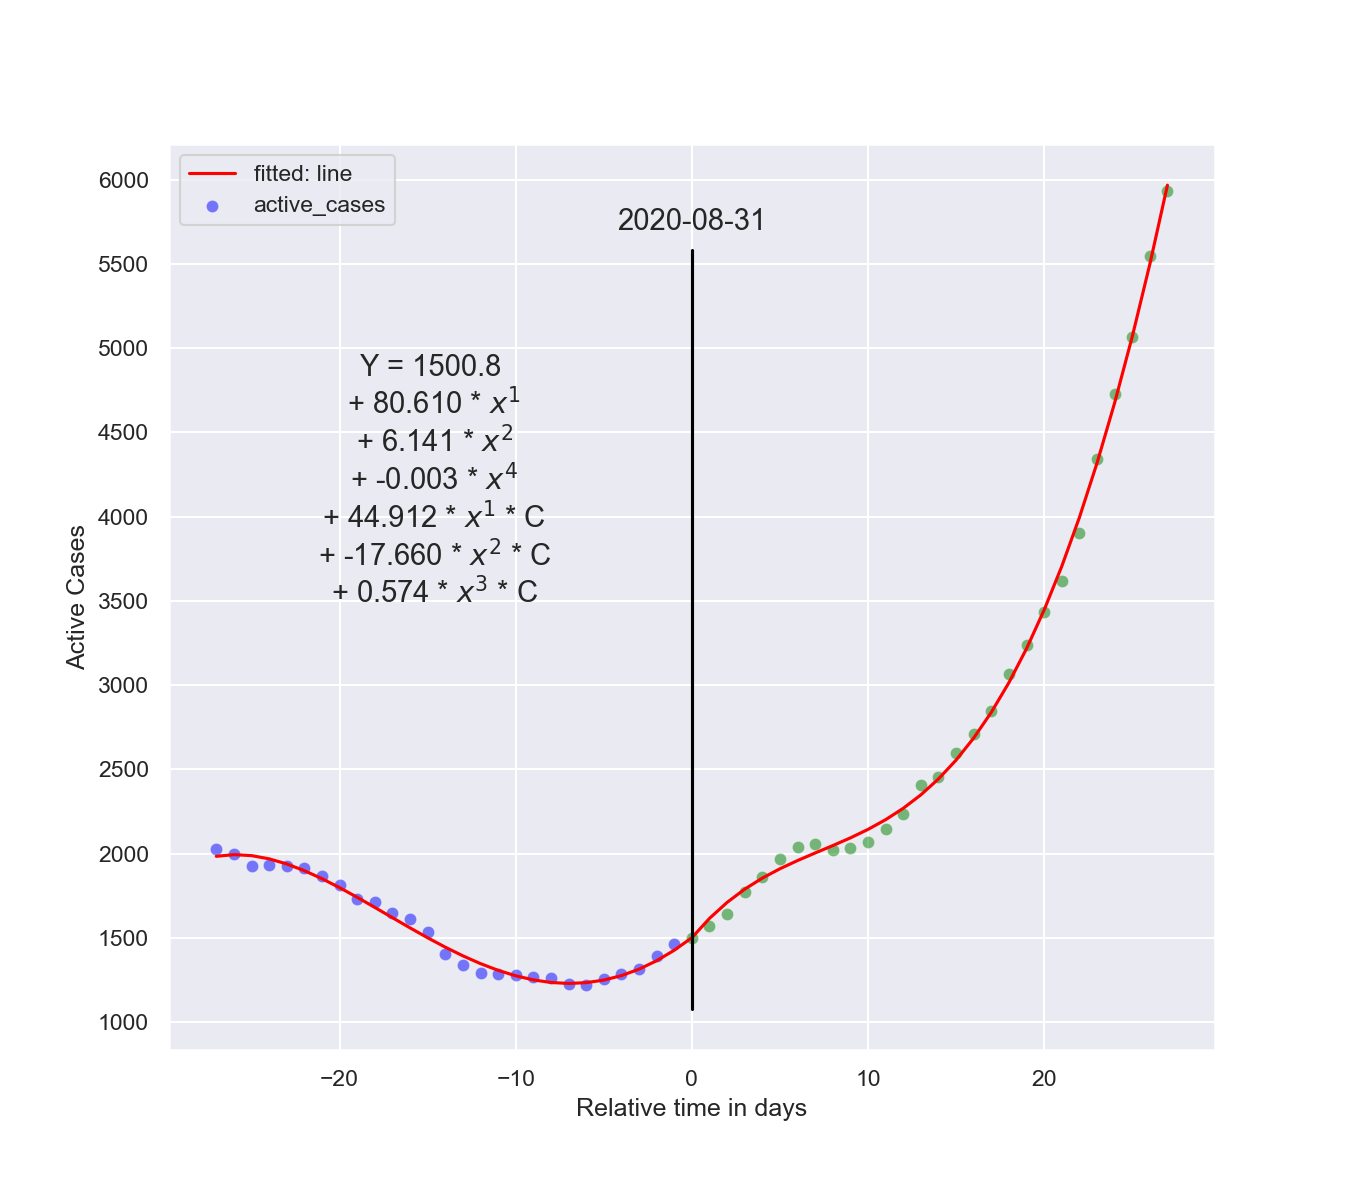

## <center>__Imports__</center>

In [23]:

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime as dt

## <center>__Functions and Classes__</center>

In [24]:
# The SIR model class
class SIR:
    """
    Models the spread of an infectious disease.
    Calculates the parameters associated with
    an infected population as per the differential
    equations of the SIR modelling. See references.
    
    References:
     1. https://en.wikipedia.org/wiki/Mathematical_modelling_of_infectious_disease
     2. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7321055/
    """

    def __init__(self, s, i, r, K, B):
        """Initialize SIR attributes."""
        # S: number of susceptible individuals
        self.s = s
        # I: number of infected individuals
        self.i = i
        # R: number of recovered (or dead) individuals
        self.r = r
        # K: fraction of infected group that 
        #    recover (or die) each day
        self.K = K
        # B: number of contacts per day that an
        #    infected person has which spreads
        #    the disease
        self.B = B
    
    def update_model(self):
        """Update the parameters as per the modelling."""
        # the susceptible population decreases thus:
        new_infections = self.B * self.s * self.i
        self.s += -new_infections
        # the recovered population changes thus:
        new_recoveries = self.K * self.i
        self.r += new_recoveries
        # the infected population increases thus:
        self.i += new_infections - new_recoveries

In [25]:
def make_rdd_plot(df, y, est, d_date, pts='no_pts'):
    """
    Plot the results of the RDD analysis, namely the 
    true points, fitted points, fit equation, discontinuity
    date.
    
    Inputs:
        df: the dataframe of x-values
        y: the dataframe of y-values
        est: the OLS modelling result
        d_date: the discontinuity date
        pts: option to plot (or not) the
             fit points.
             
    Outputs:
        generates the plots directly
    """
    
    fig= plt.figure(dpi=150,figsize=(9,8))
    # get value where target date is
    t_shift = df.loc[df['b1'] ==0].index.values[0]
    # make the plots
    sns.set()
    # plot the true y-values pre-target date
    sns.scatterplot(x=df.iloc[:t_shift]['b1'],
                    y=y.iloc[:t_shift],
                    label='active_cases',
                    color='blue',
                    marker='o',
                    alpha=0.5)
    # plot the fitted points as markers
    if pts != 'no_pts':   
        sns.scatterplot(x=df.loc[:,'b1'],
                        y=est.fittedvalues[:],
                        label='fitted: points',
                        color='red',
                        marker='D',
                        alpha=0.5)
    # plot the true y-values post-target date
    sns.scatterplot(x=df.iloc[t_shift:]['b1'],
                    y=y.iloc[t_shift:],
                    color='green',
                    marker='o',
                    alpha=0.5)
    # plot the fitted line
    x_new = add_point(df, 0.001)
    sns.lineplot(x=x_new.loc[:,'b1'],
                    y=est.predict(x_new),
                    label='fitted: line',
                    color='red',
                    marker=None,
                    alpha=1)
    # plot the line demarking the target date and annotate it
    ymin, ymax = plt.ylim()
    y_range = ymax - ymin
    y_at_target = y.loc[t_shift]  # find the y-value at target
    plt.plot([0,0], [y_at_target-0.1*y_range, y_at_target+0.1*y_range],
             color='black',);
    plt.text(0, y_at_target+0.15*y_range, 
             str(d_date).split(' ')[0], 
             fontsize=14,
             verticalalignment='top', 
             horizontalalignment='center')
    plt.xlabel('Relative time in days')
    plt.ylabel('Active Cases')
    # plot the dashed-line demarking the original
    # milestone date and annotate it
    y_at_minus_7 = y.loc[t_shift-7]  # find the y-value at t - 7 days
    plt.plot([-7,-7],[y_at_minus_7-0.1*y_range, y_at_minus_7+0.1*y_range],
             color='black',
             ls='dashed');
    plt.text(-7, y_at_minus_7+0.15*y_range, 
             str(d_date-dt.timedelta(weeks = 1)).split(' ')[0], 
             fontsize=14, verticalalignment='top', horizontalalignment='center')
    
    # add equation to plot
    for k, v in est.params.items():
        if k == 'const':
            txt = str(f"Y = {v:.1f}\n")
        elif k[0] == 'b':
            txt = txt + str(f" + {v:.3f}") + ' * $x^' + str(k[1]) + '$\n'
        elif k[0] == 'd':
            txt = txt + str(f" + {v:.3f}") + ' * $x^' + str(k[1]) + '$ * C\n'
    # plot it wrapped
    xmin, xmax = plt.xlim()
    plt.text(xmin+0.25*(xmax-xmin), ymax-0.2*y_range, txt, fontsize=14,
        verticalalignment='top', horizontalalignment='center', wrap=True)
    
def make_df_about_date(df, d_t, wks):
    """
    Prepares the dataframe for analysis
    about the discontinuity date.
    
    Inputs:
        df: the input dataframe
        d_t: the discontinuity date
        wks: the number of weeks of 
             data to extract on either
             side of d_t
             
    Outputs:
        C: the on/off matrix used in 
           RDD analysis
        y: the target vector of the analysis
        df: the x-matrix that will be 
            used to conduct feature engineering
    """
    # make a copy of the dataframe
    df = df.copy()
    # generate the time delta
    tdelta = dt.timedelta(weeks = wks)
    # make a slice of the dataframe about target date
    # for the given number of weeks
    df = df.loc[(df.date > (d_t - tdelta)) &
                (df.date < (d_t + tdelta))].reset_index(drop=True)
    # convert the date to a relative number of days
    df['date'] = df['date'] - d_t
    # make a copy of date in preparation for splitting
    # it into a pre- and post-lockdown interval
    df[['b1','2_delete']] = (df['date']
                                   .astype('str')
                                   .str
                                   .split(' ',expand=True))
    # drop unnecessary columns
    df = df.drop(['2_delete','date'],1)
    
    # convert to integer
    df['b1'] = df['b1'].astype('int')
    
    # add the constant term
    df = sm.add_constant(df)

    # make the C matrix
    C = (df['b1'] > 0) * 1
    
    # make y
    y = df['active_cases']
    df = df.drop(['active_cases'],1)
    
    return C, y, df

def get_covid(s_o, i_o, r_o, B, K, N, N_start):
    """
    Populate and infectious SIR Dataframe.
    
    Inputs:
        s_o: initial value of susceptible individuals
        i_o: initial value of infected individuals
        r_o: initial value of recovered individuals
        B: number of contacts per day that an
           infected person has which spreads
           the disease
        K: fraction of infected group that 
           recover (or die) each day
        N: Number of days to calculate
        N_start: x-value to start at
        
    Output:
    df : dataframe with values of S, I, & R for
         the given inputs
    """

    Covid_19 = SIR(s_o, i_o, r_o, K, B)

    dates = np.arange(N_start,N_start+N)
    data = np.zeros((N,3))

    df = pd.DataFrame(data, columns = ['S', 'I', 'R'], index=dates)
    
    df.loc[N_start, ['S','I','R']] = [Covid_19.s, Covid_19.i, Covid_19.r]

    for i in list(dates[1:]):
        Covid_19.update_model()
        df.loc[i,'S'] = Covid_19.s
        df.loc[i,'I'] = Covid_19.i
        df.loc[i,'R'] = Covid_19.r
        
    return df

def add_point(df, delta):
    """
    Adds a row point to a dataframe
    at x = delta.
    
    Inputs:
    df: given dataframe
    delta: new x-value
    
    Outputs:
    x: sorted x matrix with new row
       at x = delta
    """
    # copy input dataframe
    x = df.copy()
    
    # grab any row to work with
    x_row = df.iloc[0]
    # cycle through the columns 
    # and create new values accordingly
    for k, v in x_row.items():
        if k == 'const':
            pass
        elif '0' in k:
            x_row[k] = 1.0
        elif '1' in k:
            x_row[k] = delta
        elif '2' in k:
            x_row[k] = delta * delta
        elif '3' in k:
            x_row[k] = delta * delta * delta
        elif '4' in k:
            x_row[k] = delta * delta * delta * delta
        else:
            print(f"================ no function for x_row =============")

    x = x.append(x_row, ignore_index=True) # add row back
    x = x.sort_values(by='b1', ignore_index=True) # sort
    
    return x

# <center>__Reading the Data__</center>
### Data was gathered from this site: https://www.inspq.qc.ca/covid-19/donnees

In [26]:
df = pd.read_csv('chart.csv')
df = df.drop(['Par lien épidémiologique','En laboratoire'],1)
df.columns = ['date','active_cases']
df['date'] = df['date'].apply(lambda x : x.split(' ')[0])
df['date'] = pd.to_datetime(df['date'],).astype('datetime64[D]')

# <center>__First Milestone Date: March 20, 2020__</center>
## As discussed above, the target date was shifted one week to the right.
## The regression was conducted on several parameters (shown below) but p-value elimination was performed until only significant coefficients remained.

In [27]:
# create date
dt1 = dt.datetime(year=2020, month=3, day=20+7) 
# create OLS variables
C1, y1, x1 = make_df_about_date(df, dt1, 3)

In [28]:
# add the coefficients pre-target date
x1['b2'] = np.square(x1['b1'])  # square term
x1['b3'] = x1['b2'] * x1['b1']   # cube term
x1['b4'] = np.square(x1['b2'])  # quad term

# add the coefficients after the target date
x1['d0'] = x1['const'] * C1   # constant term post-target
x1['d1'] = x1['b1'] * C1   # linear term post-target
x1['d2'] = x1['b2'] * C1   # square term post-target
x1['d3'] = x1['b3'] * C1   # cube term post-target
x1['d4'] = x1['b4'] * C1   # quad term post-target

# drop some terms as a result of p-value selection
x1 = x1.drop(['b3','d1'],1)

# conduct the regression
est1 = sm.OLS(y1, x1).fit(cov_type='HC2')
est1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           active_cases   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.701e+04
Date:                Wed, 20 Jan 2021   Prob (F-statistic):           8.55e-57
Time:                        11:10:32   Log-Likelihood:                -223.56
No. Observations:                  41   AIC:                             463.1
Df Residuals:                      33   BIC:                             476.8
Df Model:                           7                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2443.4335     19.766    123.621      0.000    2404.694    2482.173
b1           434.6920     10.111     42.991      0.000     414.874     454.510
b2            21.6508      0.908     23.853      0.000      19.872      23.430
b4            -0.0152      0.001    -12.112      0.000      -0.018      -0.013
d0          -218.6643     57.540     -3.800      0.000    -331.441    -105.888
d2            29.5324      4.468      6.610      0.000      20.775      38.290
d3            -5.8513      0.448    -13.049      0.000      -6.730      -4.972
d4             0.1695      0.014     12.340      0.000       0.143       0.196
==============================================================================
Omnibus:                        0.979   Durbin-Watson:                   1.523
Prob(Omnibus):                  0.613   Jarque-Bera (JB):                1.024
Skew:                          -0.314   Prob(JB):                        0.599
Kurtosis:                       2.547   Cond. No.                     5.80e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 5.8e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

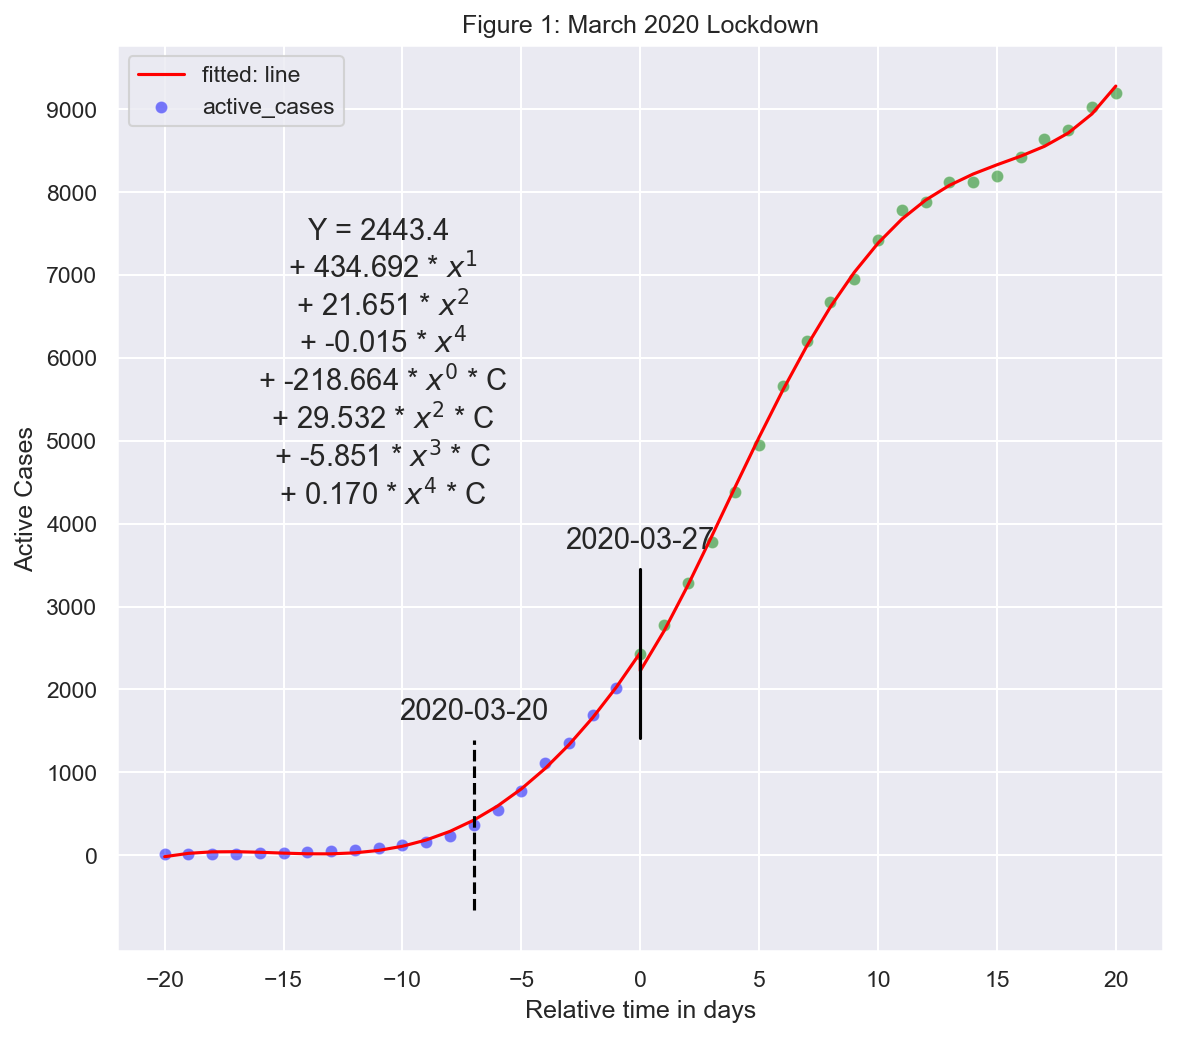

In [29]:
# create the plot
make_rdd_plot(x1,y1,est1,dt1)
# fix the y-axes
plt.yticks(np.linspace(0,9000,10));
plt.title('Figure 1: March 2020 Lockdown');

# <center>__Second Milestone Date: August 31, 2020__</center>

In [30]:
# create the date variable
dt2 = dt.datetime(year=2020, month=9, day=7) 
# create the OLS data variables
C2, y2, x2 = make_df_about_date(df, dt2, 4)

In [31]:
# add the coefficients pre-target date
x2['b2'] = np.square(x2['b1'])  # square term
x2['b3'] = x2['b2'] * x2['b1']   # cube term
x2['b4'] = np.square(x2['b2'])  # quad term

# add the coefficients after the target date
x2['d0'] = x2['const'] * C2   # constant term post-target
x2['d1'] = x2['b1'] * C2   # linear term post-target
x2['d2'] = x2['b2'] * C2   # square term post-target
x2['d3'] = x2['b3'] * C2   # cube term post-target
x2['d4'] = x2['b4'] * C2   # quad term post-target

# drop some terms as per p-value selection
x2 = x2.drop(['b2','d1'],1)


# run the OLS
est2 = sm.OLS(y2, x2).fit(cov_type='HC2')
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           active_cases   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.051e+04
Date:                Wed, 20 Jan 2021   Prob (F-statistic):           8.04e-73
Time:                        11:10:32   Log-Likelihood:                -293.22
No. Observations:                  55   AIC:                             602.4
Df Residuals:                      47   BIC:                             618.5
Df Model:                           7                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2145.4412     36.051     59.510      0.000    2074.782    2216.101
b1           104.1859      6.125     17.009      0.000      92.180     116.192
b3            -0.2757      0.029     -9.532      0.000      -0.332      -0.219
b4            -0.0055      0.001     -6.439      0.000      -0.007      -0.004
d0          -216.1365     54.819     -3.943      0.000    -323.580    -108.693
d2           -15.3168      1.841     -8.318      0.000     -18.926     -11.708
d3             1.9850      0.167     11.902      0.000       1.658       2.312
d4            -0.0296      0.003     -8.818      0.000      -0.036      -0.023
==============================================================================
Omnibus:                        2.658   Durbin-Watson:                   0.994
Prob(Omnibus):                  0.265   Jarque-Bera (JB):                1.814
Skew:                          -0.409   Prob(JB):                        0.404
Kurtosis:                       3.350   Cond. No.                     1.68e+06
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 1.68e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

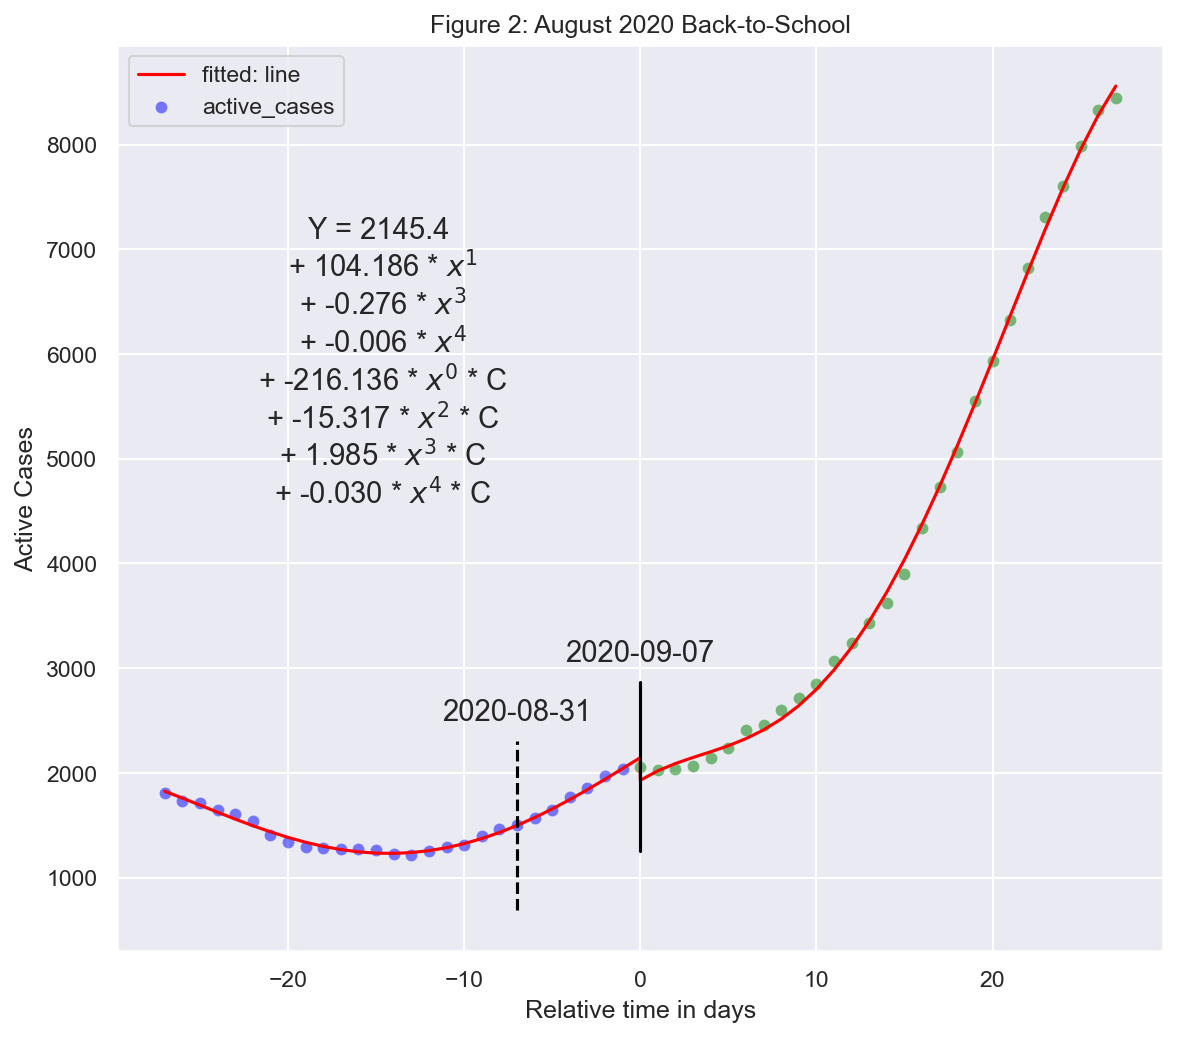

In [32]:
make_rdd_plot(x2,y2,est2,dt2)
plt.title('Figure 2: August 2020 Back-to-School');
#plt.yticks(np.linspace(1000,6000,11));


# <center>__Third Milestone Date: December 25, 2020__</center>

In [33]:
# create the date variable
dt3 = dt.datetime(year=2021, month=1, day=1) 
# create the OLS variables
C3, y3, x3 = make_df_about_date(df, dt3, 4)

In [34]:
# add the coefficients pre-target date
x3['b2'] = np.square(x3['b1'])  # square term
x3['b3'] = x3['b2'] * x3['b1']   # cube term
x3['b4'] = np.square(x3['b2'])  # quad term

# add the coefficients after the target date
x3['d0'] = x3['const'] * C3   # constant term post-target
x3['d1'] = x3['b1'] * C3   # linear term post-target
x3['d2'] = x3['b2'] * C3   # square term post-target
x3['d3'] = x3['b3'] * C3   # cube term post-target
x3['d4'] = x3['b4'] * C3   # quad term post-target

# drop some terms as per the p-value selection
x3 = x3.drop(['b4', 'd3', 'd4'],1)

# run the OLS
est3 = sm.OLS(y3, x3).fit(cov_type='HC2')
est3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           active_cases   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     2153.
Date:                Wed, 20 Jan 2021   Prob (F-statistic):           1.69e-45
Time:                        11:10:33   Log-Likelihood:                -302.92
No. Observations:                  44   AIC:                             619.8
Df Residuals:                      37   BIC:                             632.3
Df Model:                           6                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.524e+04    177.602    142.089      0.000    2.49e+04    2.56e+04
b1           509.8594     42.034     12.130      0.000     427.474     592.244
b2            10.0873      3.522      2.864      0.004       3.183      16.991
b3             0.2159      0.086      2.504      0.012       0.047       0.385
d0         -1284.3360    289.249     -4.440      0.000   -1851.254    -717.418
d1           474.6940     67.843      6.997      0.000     341.724     607.664
d2           -91.2974      6.804    -13.417      0.000    -104.634     -77.961
==============================================================================
Omnibus:                        0.080   Durbin-Watson:                   1.303
Prob(Omnibus):                  0.961   Jarque-Bera (JB):                0.063
Skew:                          -0.061   Prob(JB):                        0.969
Kurtosis:                       2.860   Cond. No.                     5.19e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 5.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

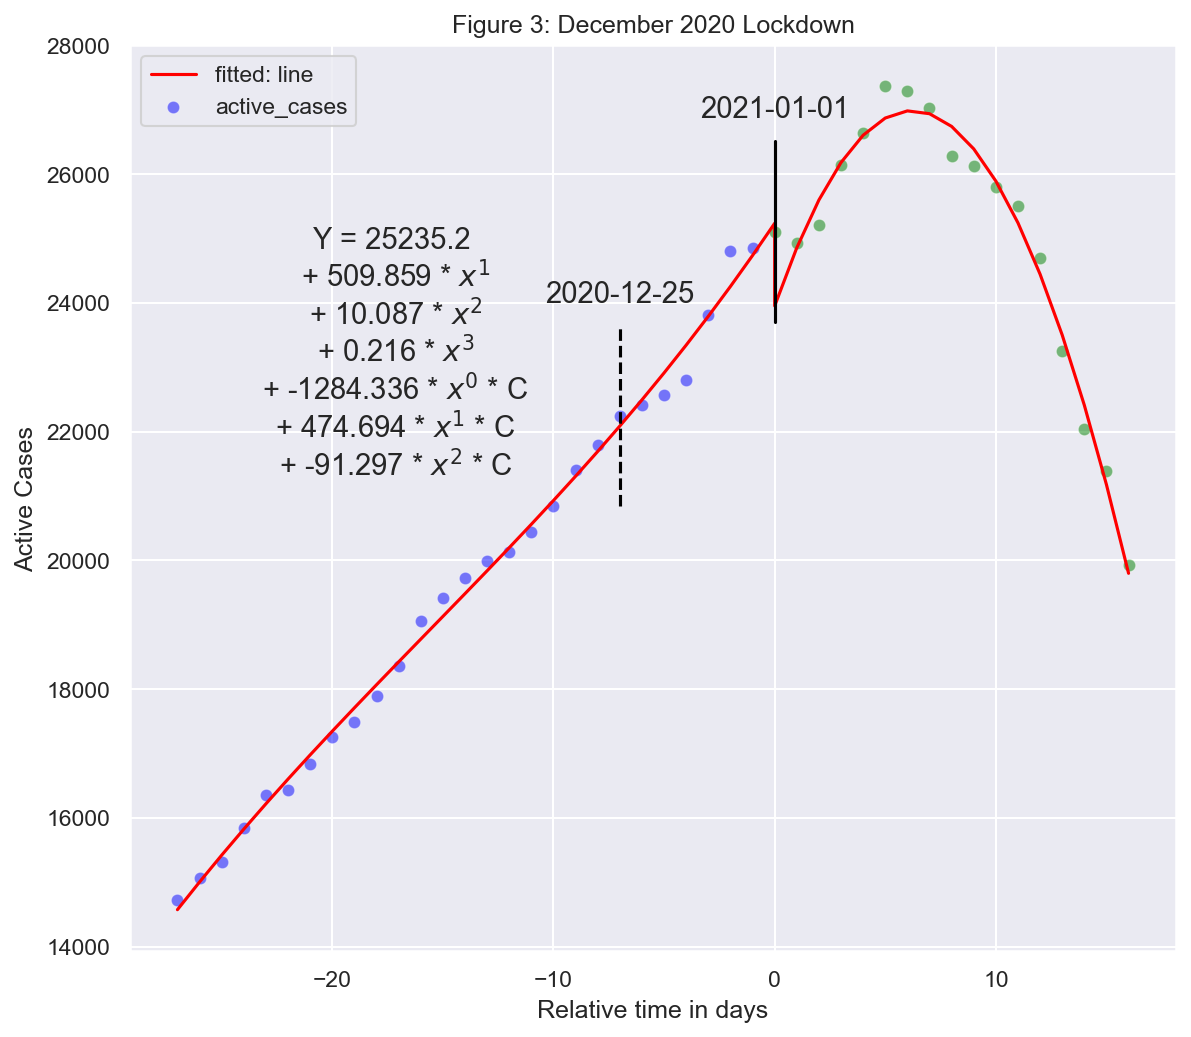

In [35]:
make_rdd_plot(x3,y3,est3,dt3)
#plt.yticks(np.linspace(1000,6000,11));
plt.title('Figure 3: December 2020 Lockdown');

# <center>__Susceptible-Infected-Removal (SIR) Modelling__</center>
## Before providing analysis, it may be worthwhile to consider the expectations for growth (or decay) of the number of active cases of a highly infectious disease. This is provided theoretically by the SIR model described here.

### References:
1. https://en.wikipedia.org/wiki/Mathematical_modelling_of_infectious_disease
2. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7321055/

## The model is based on three ordinary differential equations that describe the following parameters:
> * S: The ratio (or number) of the population susceptible to the infection
> * I: The ratio (or number) of the population infected
> * R: The ratio (or number) of the population recovered (or deceased) from the infection
## The model requires two constants:
> * B: number of contacts per day that an infected person has that result in contageon spread
> * K: fraction of the infected group that recover (or die) each day
## Note that when B is significantly bigger than K we have exponential growth.
## The equations (coded here in Class SIR):

### <center/>$\frac{\partial S(t)}{\partial t} = -B S(t) I(t)$,</center>
### <center/>$\frac{\partial I(t)}{\partial t} = B S(t) I(t) - KI(t)$,</center>
### <center/>$\frac{\partial R(t)}{\partial t} = KI(t)$,</center>

## Reference 2 applied this model to the spread of Covid-19 in several countries / states and the results are plotted below:

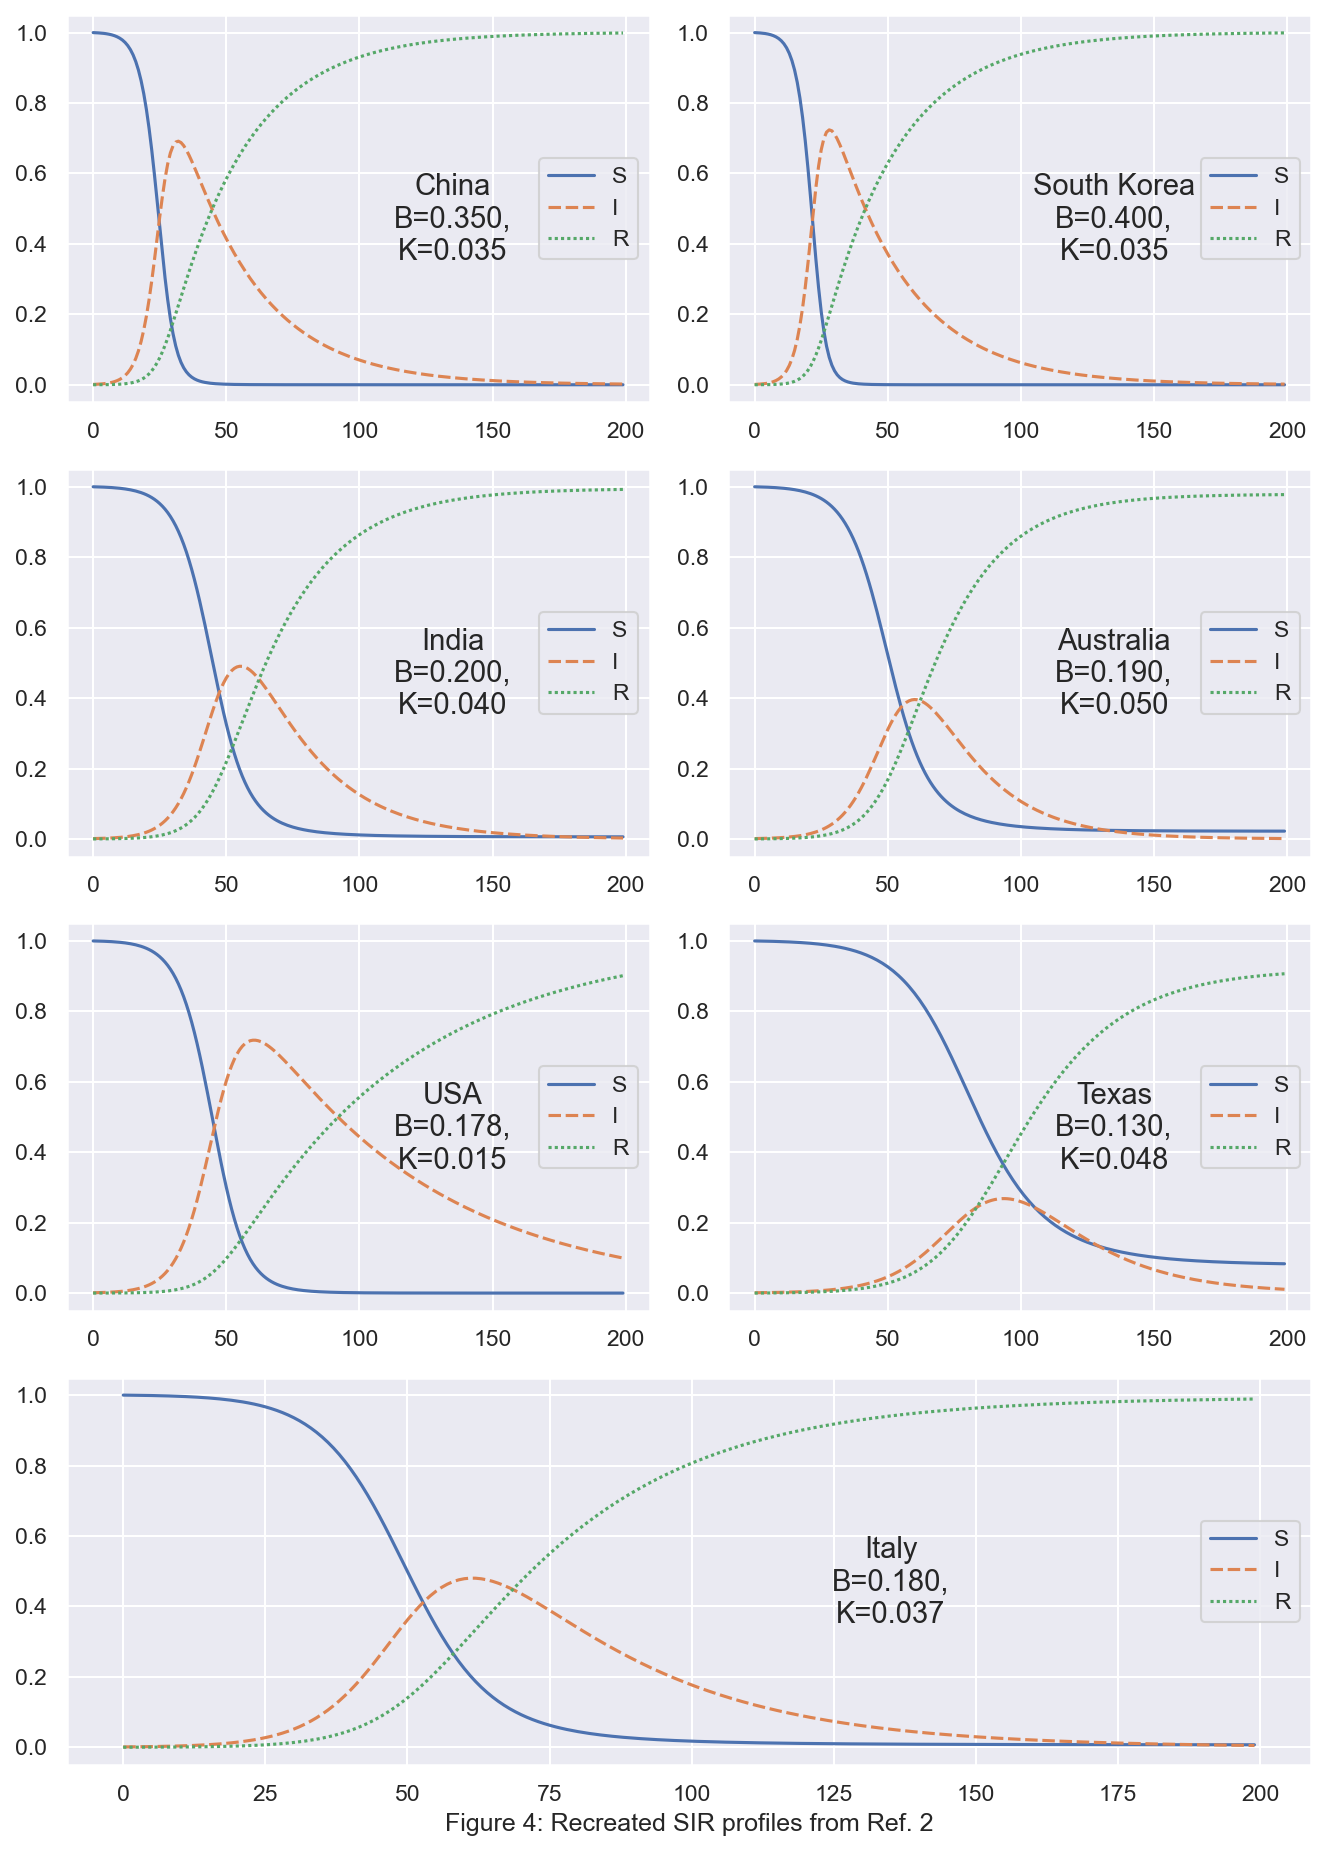

In [36]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(4, 2)
fig = plt.figure(dpi=150,figsize=(9,12.5),tight_layout=True)

def plot_ax(nx,ny,b,k,cntr):
    df_covid = get_covid(  1, 0.001,   0, b, k, 200,       0)
    if nx == 3:
        ax = fig.add_subplot(gs[nx, :])
    else:
        ax = fig.add_subplot(gs[nx, ny])
    sns.lineplot(data=df_covid,ax=ax);
    plt.text(135, 0.6, cntr+f"\nB={b:.3f},\nK={k:.3f}", fontsize=14,
             verticalalignment='top', horizontalalignment='center', wrap=True)

plot_ax(0,0,0.35, 0.035, 'China')
plot_ax(0,1,0.40, 0.035, 'South Korea')
plot_ax(1,0,0.20, 0.040, 'India')
plot_ax(1,1,0.19, 0.050, 'Australia')
plot_ax(2,0,0.178, 0.015, 'USA')
plot_ax(2,1,0.130, 0.048, 'Texas')
plot_ax(3,0,0.180, 0.037, 'Italy')
plt.xlabel('Figure 4: Recreated SIR profiles from Ref. 2');

## We can compare these theoretical (although matched in the litterature) results with the figure below which shows the historical trend of active cases in Quebec. We see that the traditional SIR model would require modification to match overall trends. As explained in the reference, Covid-19 surges can occur when pockets of susceptible people within a population are exposed. The authors adapted the model in order to account for this.
## However, for our purposes here, we will use the traditional model and assume that it provides some value over a short period of time.

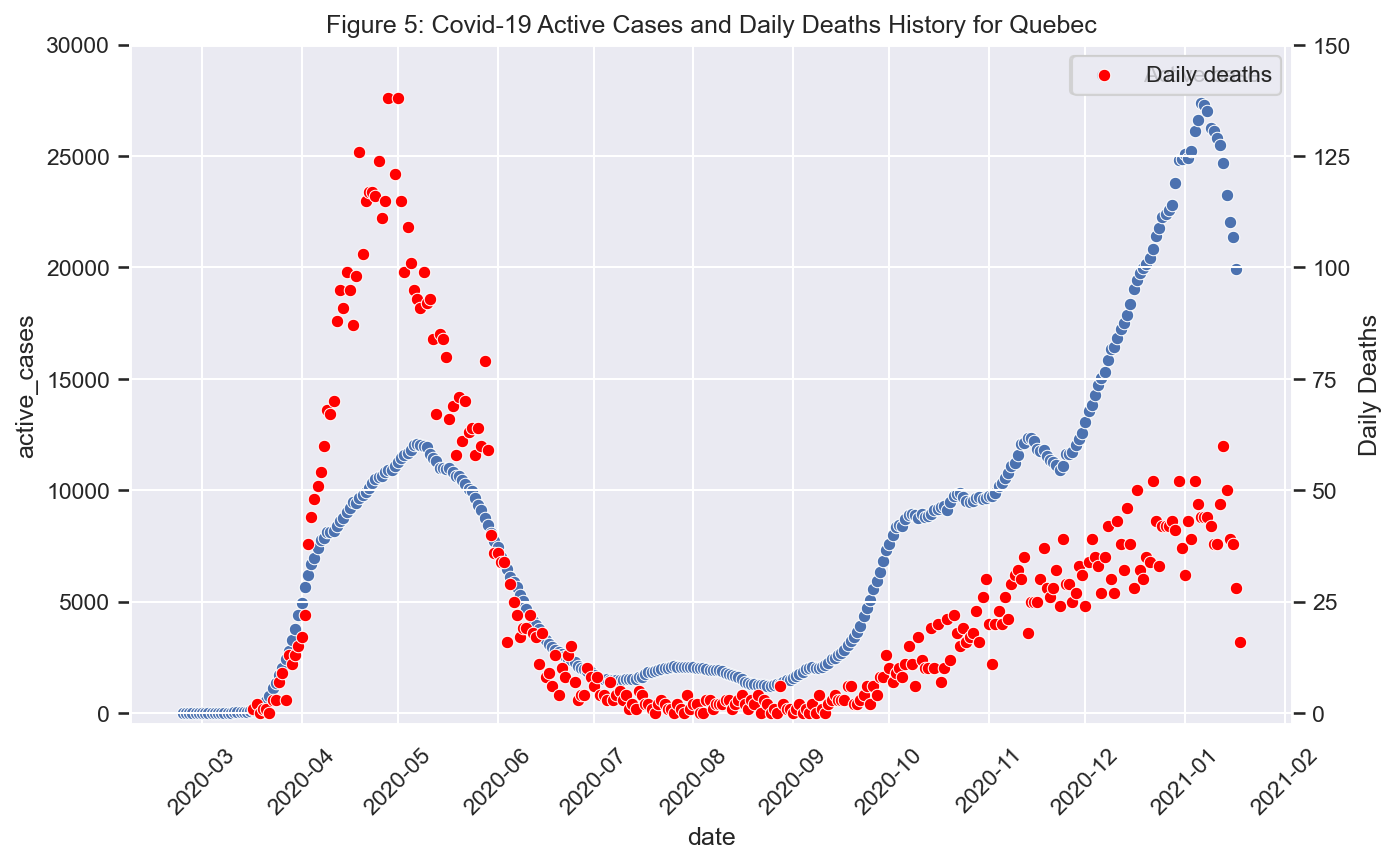

In [37]:
fig = plt.figure(dpi=150,figsize=(10,6))
ax = sns.scatterplot(data=df, 
                     x='date', 
                     y='active_cases',
                     label='Active cases')
plt.xticks(rotation=45);
plt.ylim([-500,30000])
df_deaths = pd.read_csv('DailyDeaths.csv')
df_deaths['date'] = df_deaths['DateTime'].apply(lambda x : x.split(' ')[0])
df_deaths['date'] = pd.to_datetime(df_deaths['date'],).astype('datetime64[D]')
ax2 = ax.twinx()
sns.scatterplot(data=df_deaths, 
                x='date', 
                y='Daily Deaths',
                ax=ax2,
                label='Daily deaths',
                color='red');
plt.ylim([-2.5,150]);
plt.yticks([0,25,50,75,100,125,150]);
plt.title('Figure 5: Covid-19 Active Cases and Daily Deaths History for Quebec');

# <center/>__Adding SIR Modelling to the Results__</center>

## In what follows below, we add a SIR model and tweak the B and K values to match the left-hand side (LHS) of the curve in order to draw conclusions about the right-hand side (RHS) progress.

# <center>__First Milestone Date: March 20, 2020__</center>

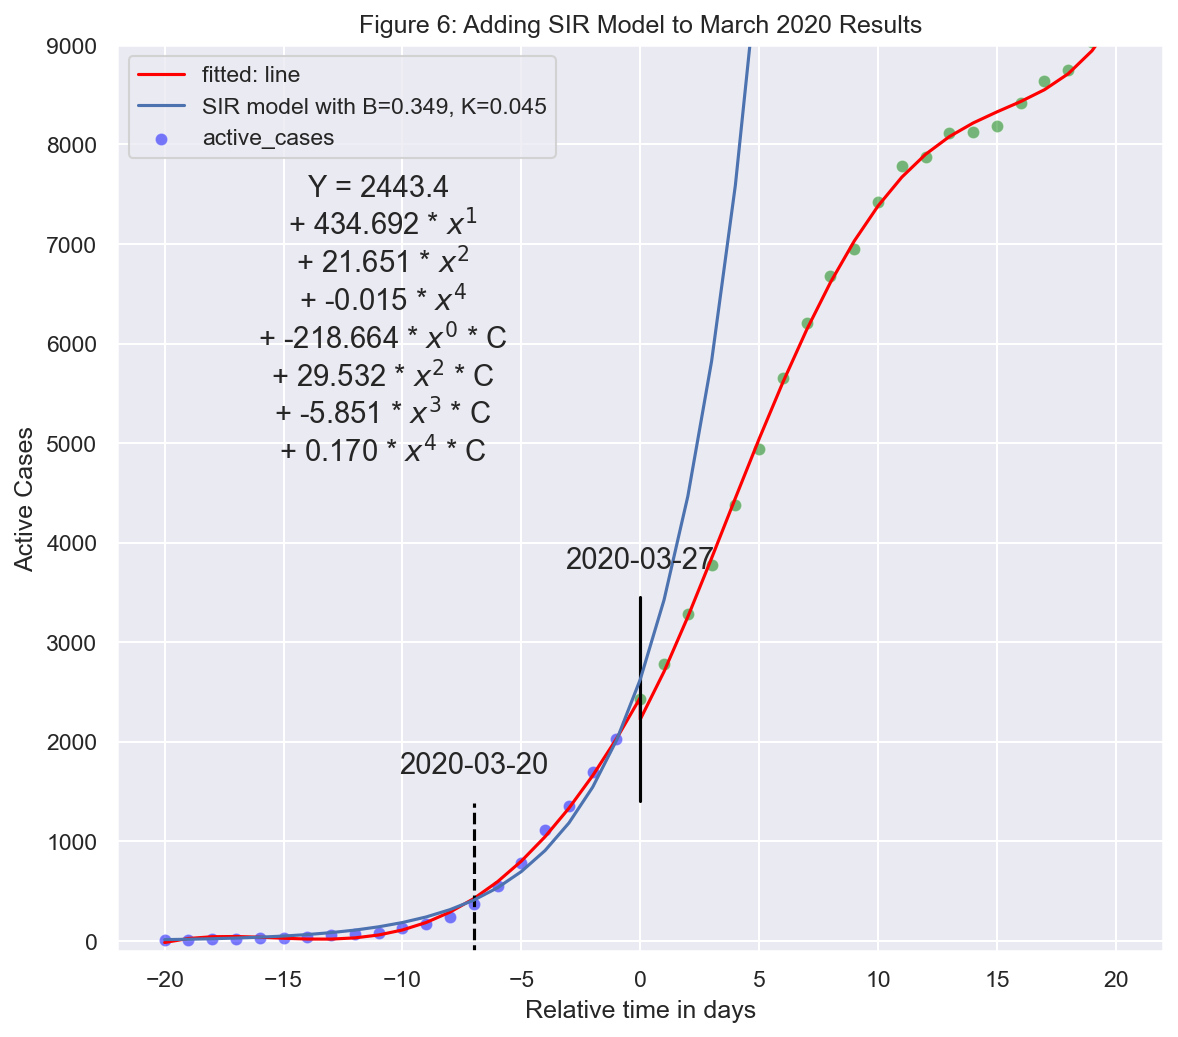

In [38]:
make_rdd_plot(x1,y1,est1,dt1)
QC_POP = 8_574_571 # population of Quebec 2020
B = 0.349 # number of infectious contacts per day per individual
K = 0.045 # fraction of recovered (or deaths) among infected

df_covid = get_covid(1, 13/QC_POP, 0, B, K, 40, -20) * QC_POP
sns.lineplot(data=df_covid,x=df_covid.index, y='I',label=f"SIR model with B={B:.3f}, K={K:.3f}");
#plt.xlim([0,30])
plt.ylim([-100,9000]);
plt.yticks(np.linspace(0,9000,10));
plt.title('Figure 6: Adding SIR Model to March 2020 Results');

## <center/>__Analysis: March 2020__ </center>

## It is clear that a discontinuity in the behaviour of the data occurs one week after the lockdown came into efffect. The SIR modelling helps us understand this as well. The SIR model indicates that an exponential rise in active cases was well underway and continued for a week past the lockdown. The data behaviour then switched from exponential to negative curvature (slope decreasing with time) followed by an inflection point.

## Note that the values of B and K required to match the LHS are very much aligned with the values provided for some countries (Figure 4).

## Figure 5 indicates that the largest surge in deaths started to occur simultaneously at this time. However, for the RHS of Figure 6, these deaths can only account for about 1,000 net losses in active cases. Therefore, we conclude that the overall lessoning of the curve was due in majority to a marked decrease in new infections as a result of the lockdown.

# <center>__Second Milestone Date: August 31, 2020__</center>

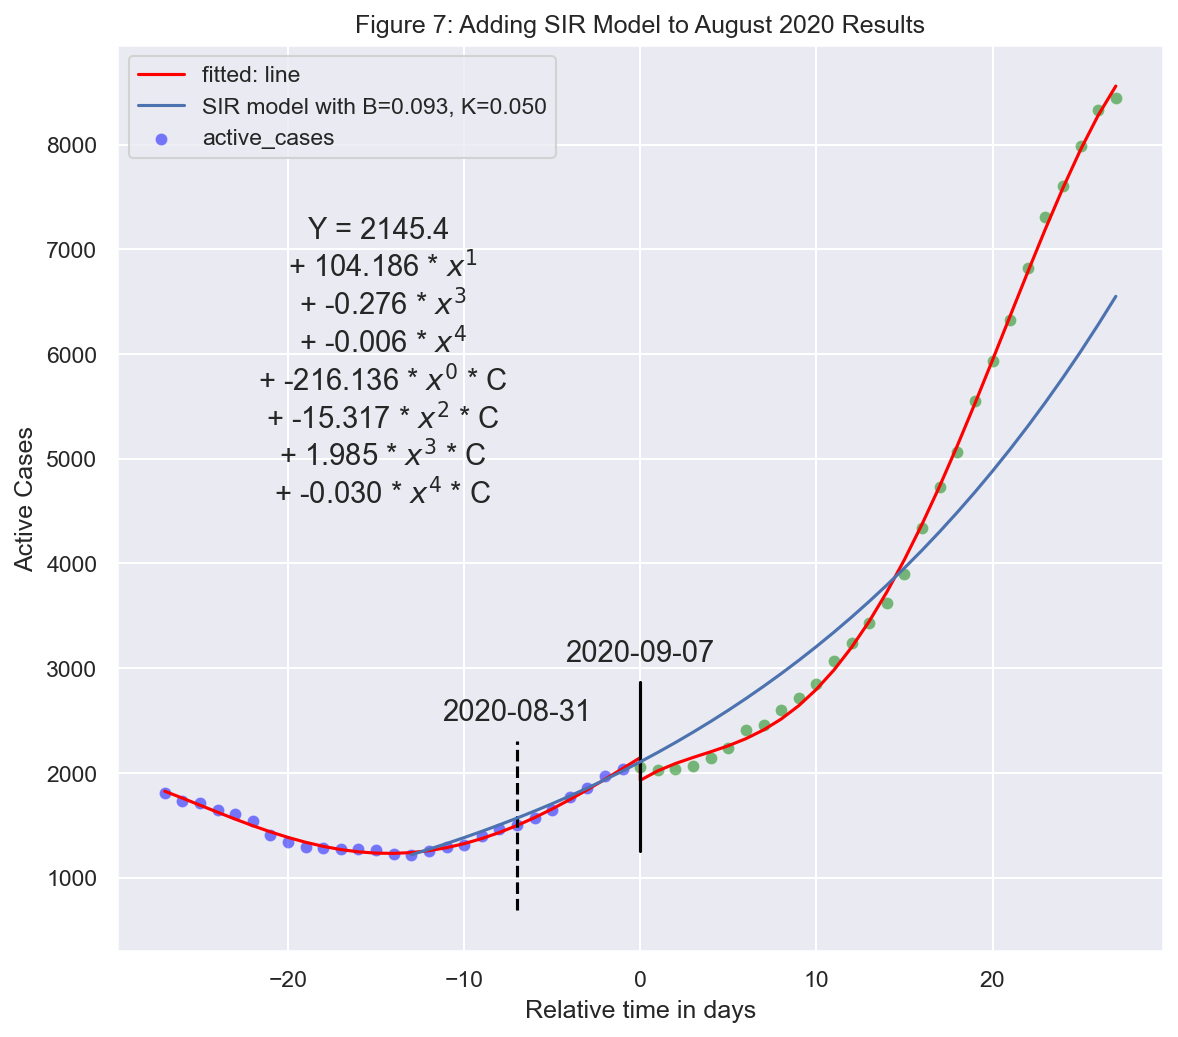

In [39]:
make_rdd_plot(x2,y2,est2,dt2)
QC_POP = 8_574_571 # population of Quebec 2020
B = 0.093 # number of infectious contacts per day per individual
K = 0.050 # fraction of recovered (or deaths) among infected

df_covid = get_covid(1, 1218/QC_POP, 0, B, K, 41, -13) * QC_POP
sns.lineplot(data=df_covid,x=df_covid.index, y='I',label=f"SIR model with B={B:.3f}, K={K:.3f}");
plt.title('Figure 7: Adding SIR Model to August 2020 Results');

## <center/>__Analysis: August 2020__ </center>

## It is clear that a discontinuity in the behaviour of the data occurs one week after the milestone date. Note that the growth factor B is lower now reflecting the almost steady-state achieved in the summer of 2020 (see Figure 5). The trend levelled off somewhat but then began an exponential rise. It is unclear how to explain the levelling-off behaviour.

## The extrapolated SIR model into the RHS emphasizes the drastic effect of the new exponential rise in cases. This new wave was due to the back-to-school milestone.

# <center>__Third Milestone Date: December 25, 2020__</center>

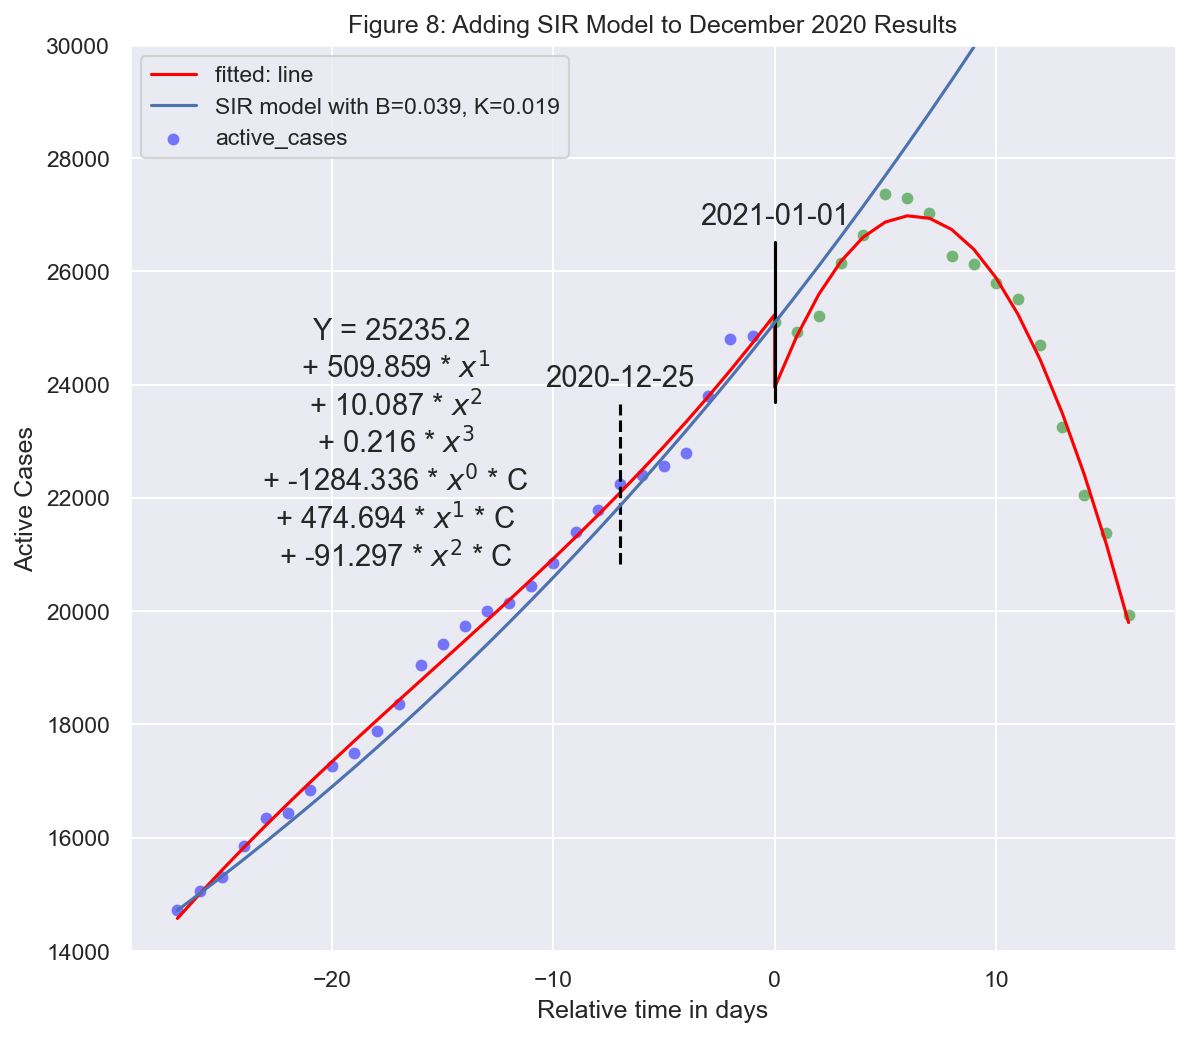

In [40]:
make_rdd_plot(x3,y3,est3,dt3)
QC_POP = 8_574_571 # population of Quebec 2020
B = 0.039 # number of infectious contacts per day per individual
K = 0.019 # fraction of recovered (or deaths) among infected

df_covid = get_covid(1, 14716/QC_POP, 0, B, K, 37, -27) * QC_POP
sns.lineplot(data=df_covid,x=df_covid.index, y='I',label=f"SIR model with B={B:.3f}, K={K:.3f}");
plt.ylim([14000,30000]);
plt.title('Figure 8: Adding SIR Model to December 2020 Results');

## <center/>__Analysis: December 2020__ </center>

## It is clear that a discontinuity in the behaviour of the data occurs one week after the milestone date. Note the similar values of B and K reflecting the almost linear growth (as opposed to exponential growth) achieved throughout December 2020 (see Figure 5). This trend breaks at the milestone date and the number of active cases starts to decline parabolically.

## Looking at the number of deaths in Figure 5 for this timeframe indicates a flat if not decreasing trend. Therefore, we can conclude the drop in active cases is due to the reduced spread of infections via the lockdown order.

# <center/> __Conclusions__ </center>

## The Covid-19 active cases data for Quebec does lend itself to an RDD analysis. Periods of 3 to 4 weeks about a milestone date were analysed. The continuity occured one week after the milestone date.

## <center/> __Method__ </center>

## For each event, the starting point was a forth-order polynomial for both the LHS and RHS. The coefficient with the greatest p-value was removed and the regression repeated until all coefficients were significant.
## The justification for adding a week to the milestone date is provided at the top of this document.

## <center/>__Timeframe and Poly Order__ </center>

## The timeframe was varied to capture a consistent behavior on either side of milestone. While 4th-order polynomials are perhaps excessive, the fits were considered adequate.
## However, for August 2020, the discontinuity can be said to be more of a cusp (continuity in values but change of slope). Varying the timeframe and polynomials might change the appearance of the discontinuity but it is clear that a slope discontinuity is always present.

## <center/>__P-Values__ </center>

## As described above, all p-values of the final fit indicate a rejection of the null hypothesis (coefficient = 0). The significance for an RDD analysis is that the RHS of the figure does indeed have a different nature than that of the LHS. The coefficients that are multiplied by C then change the nature of the curves beyond the milestone date. For example, in Figure 8 the constant term, the l|inear term and the quadratic term all change beyond the milestone date.